# Loading the dataset

In [ ]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download a file based on its file ID.

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1eqN9Xhg_P6N6GliAZ2PkTpg6rnxeP5Ua' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('tweet_data.csv')  

# Installing dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style('dark')
from wordcloud import WordCloud
from textblob import TextBlob
import nltk

In [ ]:
df = pd.read_csv('tweet_data.csv', lineterminator='\n')
df = df.drop(['Unnamed: 0', 'Text Lemmatized'],axis=1)

# Sentiment Analysis using TextBlob

In [ ]:
df['TBScore'] = df['Clean Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Convert polarity score into sentiment categories
df['Sentiment'] = df['TBScore'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [ ]:
df.sample(10)

,Datetime,Text,Username,Like Count,Display Name,Clean Text,TBScore,Sentiment
460653,2020-12-14,A nurse was the first to receive the COVID-19 ...,FoundersGyan,1,FoundersGyan,a nurse was the first to receive the covid-19 ...,0.25,Positive
1004832,2020-12-29,@TheLast61921895 @AddressingLife @Rheum2improv...,Yvesjazz123,9,Miss,the vaccine will not prevent her from gettin...,-0.40,Negative
698266,2020-12-18,My generation is more scared of the vaccine th...,__Lanai_,0,L A N A I,my generation is more scared of the vaccine th...,0.35,Positive
169938,2020-12-05,@Timcast @SaltyCracker9 \nNo need for vaccines...,realJoe_Martin,0,Joseph Martin,"\nno need for vaccines, covid pandemic is o...",0.00,Neutral
846632,2020-12-22,Dallas medics will be among the first city wor...,dallasnews,9,Dallas Morning News,dallas medics will be among the first city wor...,0.25,Positive
624460,2020-12-17,Latest: Doctor answers questions about COVID v...,WatsupAmericas,0,WatsupAmericas,latest: doctor answers questions about covid v...,0.50,Positive
393486,2020-12-12,Coordination efforts for delivering COVID-19 v...,LAVI__Z,0,LAVIZ,coordination efforts for delivering covid-19 v...,0.00,Neutral
885298,2020-12-23,if u ever sat on santas lap then u do...,yosanoslove,1,bo / cosmo 👾,if you ever sat on santas lap then you...,0.00,Neutral
302451,2020-12-09,9 out of 10 people in poor countries are set t...,KaiTab,0,Kai Tabacek,9 out of 10 people in poor countries are set t...,-0.20,Negative
772408,2020-12-20,One of the sequelae of Covid-19 infection is i...,lilienfeld1,11,david lilienfeld,one of the sequelae of covid-19 infection is i...,0.20,Positive


**Polarity frequency**

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000.]), <a list of 8 Text major ticklabel objects>)

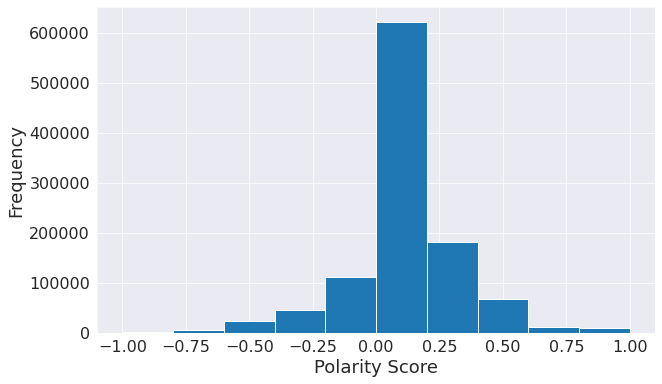

In [ ]:
fig = plt.figure(figsize=(10, 6))
df['TBScore'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

**Making wordclouds**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords_to_add = ['covid', 'via', 'v','a','c','c','i','n','e', 'people', 'get','getting','vaccination', 'amp', 'vaccine', 'covid19', 'covidvaccine']
stop_words.extend(new_stopwords_to_add)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


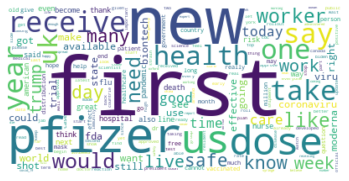

In [ ]:
pos_tweets=df[df["Sentiment"]=="Positive"]
txt=" ".join(tweet for tweet in pos_tweets["Clean Text"])
import re
line = re.sub('vaccine+', "", txt)

wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

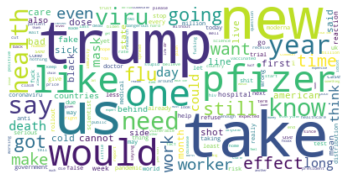

In [ ]:
neg_tweets=df[df["Sentiment"]=="Negative"]
txt=" ".join(tweet.lower() for tweet in neg_tweets["Clean Text"])
line = re.sub('vaccine+', "", txt)
wordcloud = WordCloud(collocations = False,background_color = 'white', stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Graphing the people's opinions**

In [ ]:
def get_value_counts(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df

In [ ]:
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,161309,14.93
1,Neutral,441513,40.85
2,Positive,477931,44.22


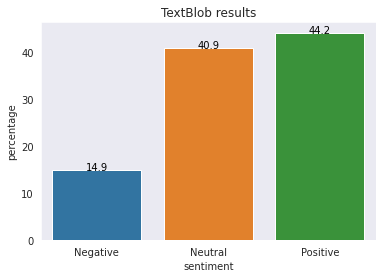

In [ ]:
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
ax.set_title('TextBlob results')

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

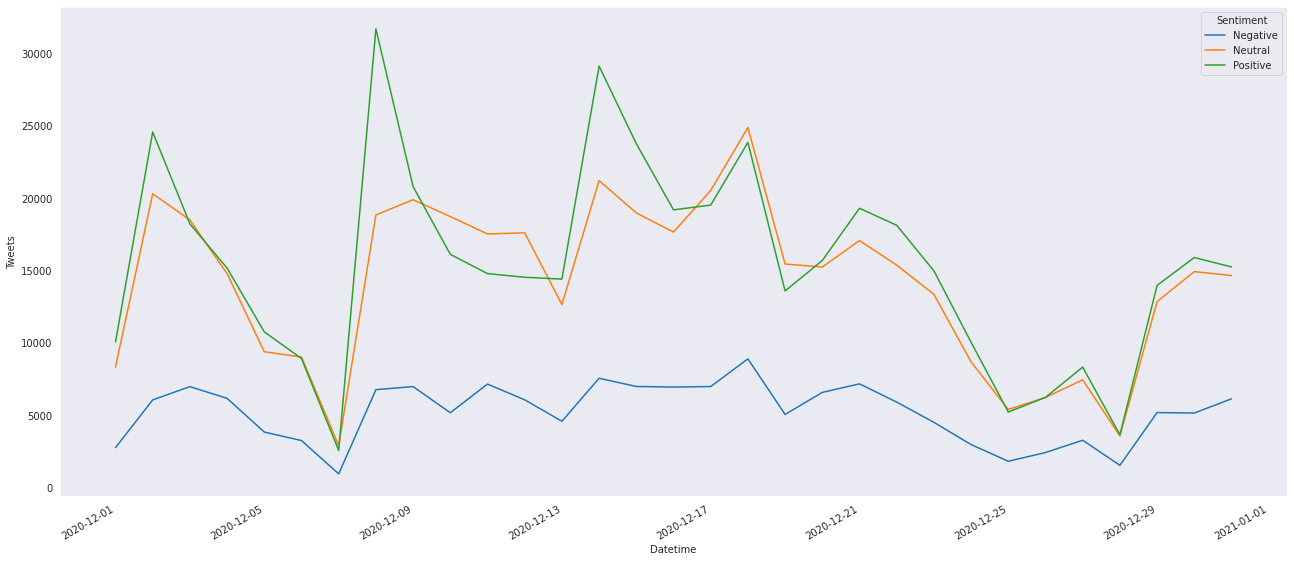

In [ ]:
# Plotting timeseries plot
df["Datetime"] = pd.to_datetime(df.Datetime) 
timeline = df.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)
ax.figure.autofmt_xdate()

**Checking out top 10 negative tweets**

In [ ]:
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='TBScore', ascending=True)[['Text', 'TBScore', 'Username']].reset_index(drop=True).head(n=10)

,Text,TBScore,Username
0,I’m feelin ✨manic✨ today &amp; im so frustrated bc I can’t see no one or do NOTHING. \n\nCOVID GO AWAY!!! i want my vaccine NOW!!,-1.0,earthybubblezz
1,Tennessee Nurse Gets COVID Vaccine – Received Bells Palsy As A Bonus: “I Think This Vaccination Is The Worst Thing Ever” (Video) https://t.co/kmT2qLfwCB,-1.0,TheVanillaSpice
2,"@karatemaster7 @sanjep @jonathanvswan @mikeallen And insulting me gets you nowhere. Let me guess.. you think Trump should be president for another 4 years, that there are microchips in the Covid vaccines, and that COVID is a hoax.",-1.0,hippiechicken12
3,This is outrageous! Why the hell did Rubio get the Covid vaccine 😵🤬 https://t.co/IvEc6dOFQW,-1.0,DWalkerHunt
4,"‘Truly, Truly Evil': Tucker Carlson Slammed For Sowing Doubt About COVID-19 Vaccines https://t.co/qmXQsbtLBU via @Yahoo",-1.0,CheeseQueen1976
5,@PeregrineMister @A2SchoolsSuper @A2Return That update is awful. Why is she even mentioning child vaccines for COVID? This feels like laying the groundwork for a moving of the goalposts... https://t.co/0FfL05cmFN,-1.0,SMHred
6,"Bravo! On the heels of a COVID scare myself (risk of being a physician these days), I am hopeful that this will be the beginning of the end of this terrible moment in our lives. I’m eagerly and patiently waiting in line! #FightCOVID19 #CovidVaccine https://t.co/wd9Rbc8zEe",-1.0,TMaganaMD
7,.@fordnation .@OntarioPCParty .@AndreaHorwath 24/7 #COVID19 vaccinations 💉 now. The vaccine should not be sitting in cold storage for days on end! It should be flying off the shelves like the #PS5! COVID-19 didn’t take a vacation! #ONPoli #TOPoli #CDNPoli https://t.co/QnuaDN5WXv,-1.0,sethlwilson
8,So the US reports the highest number of COVID deaths in 1 day and it has me wondering what the plan is. @realDonaldTrump @GOP @SenateGOP @HouseGOP anything? Or are we just gonna hope the vaccine is the save all? You’re lack of leadership/response is pathetic! @CNN @FoxNews,-1.0,jeffteed66
9,don't get the covid vaccine guys. worst mistake of my life,-1.0,lZUTSUMl


**Checking out top 10 positive tweets**

In [ ]:
df.sort_values(by='TBScore', ascending=False)[['Text', 'TBScore', 'Username']].reset_index(drop=True).head(n=10)


,Text,TBScore,Username
0,This makes me so happy! ⁦@UUtah⁩ ⁦@UofUHealth⁩ #CovidVaccine https://t.co/I4ZmPegUWR,1.0,IAmEricKenney
1,"#wave1 covid vaccine finished. Thank you Yeovil PCN you have been an AWESOME team, one very proud CD.... bring on Jan 😊 https://t.co/ZYG6HcLWgt",1.0,DalbyWelsh
2,Great discussion @kidsconsidered on #CovidVaccine !! https://t.co/BbhIz6Oa29,1.0,empulsepodcast
3,Excellent look at covid vaccine risk. Thank you @BretWeinstein &amp; @HeatherEHeying \nhttps://t.co/wJXOCJifqL,1.0,ClobberChop
4,Excellent thread about how the COVID vaccines work! Educate yaself! https://t.co/54HNgFZNue,1.0,WhiteTowerPod
5,"Govt trying to ‘bridge’ gap with farmers &amp; Covid vaccine on Santa’s gift list this Christmas\n\nThePrint brings you the best cartoons of the day, in #LastLaughs\n\nhttps://t.co/7mfOBpB44B",1.0,ThePrintIndia
6,"@LynissaH They have those for the COVID vaccines lol! They were literally calling them ""pods"" on the news 😂",1.0,KendraAnn4
7,"Today my rheumatologist gave me permission* to get any of the COVID vaccines. While he doesn’t think they’ll work as well on me because of my suppressed immune system, this is awesome news.",1.0,kmitchellauthor
8,#UK medicine regulator to assess best dose regimen of Oxford/#AstraZeneca #COVIDvaccine https://t.co/HFQZgDLcQd,1.0,Dylakk
9,"I work with covid patients but I’m honestly so happy our politicians are getting the vaccine before me, slay legislators!",1.0,NatedeVeer
